In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random 


cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Fix all random seeds
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Worker seeding for dataloader workers
def seed_worker(worker_id):
    # Ensures each worker has the same seed derived from the global seed
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
# DataLoader setup with fixed generator
g = torch.Generator()
g.manual_seed(seed)
None

# Download [data](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification)

In [3]:
BATCH_SIZE = 32

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def rgb_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f).convert('RGBA')
        return img.convert('RGB')

data_dir = '/kaggle/input/muffin-vs-chihuahua-image-classification'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'], loader=rgb_loader),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'], loader=rgb_loader)
}

full_train_dataset = image_datasets['train']

# Define the split ratio (e.g., 80% train, 20% validation)
train_ratio = 0.8
val_ratio = 1.0 - train_ratio
train_size = int(train_ratio * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Perform the random split
train_dataset, val_dataset = torch.utils.data.random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=g
)

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['test']
image_datasets['train'] = train_dataset
image_datasets['val'] = val_dataset

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=BATCH_SIZE,
        shuffle=True, 
        num_workers=4, worker_init_fn=seed_worker, 
        generator=g,
    ) 
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['test'].classes
print(f'Dataset sizes: {dataset_sizes}')
print(f'Class names: {class_names}')

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Dataset sizes: {'train': 3786, 'val': 947, 'test': 1184}
Class names: ['chihuahua', 'muffin']
Using cuda device


# Visualise data

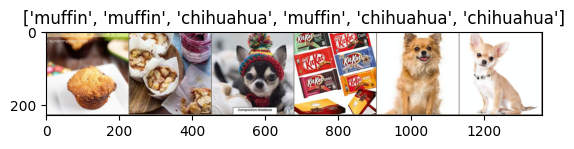

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:6])

imshow(out, title=[class_names[x] for x in classes[:6]])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train' and scheduler:
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best Val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

# Training the model

In [6]:
def evaluate_best_model(model):
    model.eval()
    
    running_corrects = 0
    
    if 'test' not in dataloaders:
        return 0.0

    print("-" * 10)
    print("Starting Final Test Evaluation...")
    
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'Final Test Acc with Best Model: {test_acc:.4f}')
    print("-" * 10)
    
    return test_acc

# Visualizing the model predictions

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def get_params_number(model):
    num_params = sum(p.numel() for p in model.parameters())
    num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {num_params:,}")
    print(f"Trainable parameters: {num_trainable:,}")

# Resnet152

In [9]:
learning_rate = 1e-3 
num_epochs = 20

model_resnet = models.resnet152(weights='IMAGENET1K_V1')
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2)

model_resnet = model_resnet.to(device)

optimizer_resnet = optim.AdamW(model_resnet.parameters(), lr=learning_rate)
T_max = num_epochs  
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=T_max)

criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 199MB/s]  


In [10]:
get_params_number(model_resnet)

Total parameters: 58,147,906
Trainable parameters: 58,147,906


In [11]:
model_resnet = train_model(model_resnet, criterion, optimizer_resnet, exp_lr_scheduler,
                       num_epochs=num_epochs)
evaluate_best_model(model_resnet)

Epoch 0/19
----------
train Loss: 0.2855 Acc: 0.8928
val Loss: 0.6241 Acc: 0.8532

Epoch 1/19
----------
train Loss: 0.1801 Acc: 0.9319
val Loss: 0.1856 Acc: 0.9240

Epoch 2/19
----------
train Loss: 0.1323 Acc: 0.9496
val Loss: 0.1253 Acc: 0.9556

Epoch 3/19
----------
train Loss: 0.0954 Acc: 0.9638
val Loss: 0.2454 Acc: 0.9335

Epoch 4/19
----------
train Loss: 0.0936 Acc: 0.9659
val Loss: 0.0629 Acc: 0.9799

Epoch 5/19
----------
train Loss: 0.0777 Acc: 0.9741
val Loss: 0.1257 Acc: 0.9461

Epoch 6/19
----------
train Loss: 0.0496 Acc: 0.9826
val Loss: 0.1728 Acc: 0.9314

Epoch 7/19
----------
train Loss: 0.0494 Acc: 0.9842
val Loss: 0.0912 Acc: 0.9652

Epoch 8/19
----------
train Loss: 0.0208 Acc: 0.9931
val Loss: 0.0699 Acc: 0.9778

Epoch 9/19
----------
train Loss: 0.0392 Acc: 0.9857
val Loss: 0.0603 Acc: 0.9799

Epoch 10/19
----------
train Loss: 0.0161 Acc: 0.9942
val Loss: 0.0382 Acc: 0.9852

Epoch 11/19
----------
train Loss: 0.0058 Acc: 0.9989
val Loss: 0.0447 Acc: 0.9873

Ep

tensor(0.9856, device='cuda:0', dtype=torch.float64)

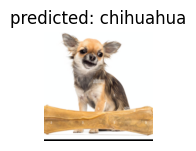

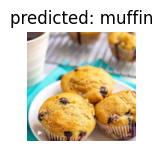

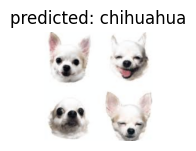

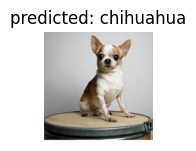

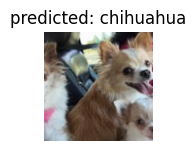

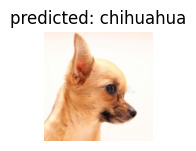

In [12]:
visualize_model(model_resnet)

plt.ioff()
plt.show()

# Vit_b_16

In [13]:
learning_rate = 1e-3
num_epochs = 20

model_vit = models.vit_b_16(weights='IMAGENET1K_V1')
num_ftrs = model_vit.heads.head.in_features
model_vit.heads.head = nn.Linear(num_ftrs, 2)

model_vit = model_vit.to(device)

optimizer_vit = optim.AdamW(model_vit.parameters(), lr=learning_rate)
T_max = num_epochs  
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_vit, T_max=T_max)

get_params_number(model_vit)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 155MB/s]  


Total parameters: 85,800,194
Trainable parameters: 85,800,194


In [14]:
model_vit = train_model(model_vit, criterion, optimizer_vit, exp_lr_scheduler,
                       num_epochs=num_epochs)

evaluate_best_model(model_vit)

Epoch 0/19
----------
train Loss: 0.7017 Acc: 0.6244
val Loss: 0.4866 Acc: 0.7835

Epoch 1/19
----------
train Loss: 0.5009 Acc: 0.7647
val Loss: 0.4096 Acc: 0.8163

Epoch 2/19
----------
train Loss: 0.4118 Acc: 0.8212
val Loss: 0.3829 Acc: 0.8585

Epoch 3/19
----------
train Loss: 0.3865 Acc: 0.8257
val Loss: 0.3352 Acc: 0.8648

Epoch 4/19
----------
train Loss: 0.3528 Acc: 0.8431
val Loss: 0.3109 Acc: 0.8743

Epoch 5/19
----------
train Loss: 0.3321 Acc: 0.8568
val Loss: 0.3430 Acc: 0.8405

Epoch 6/19
----------
train Loss: 0.2869 Acc: 0.8780
val Loss: 0.3359 Acc: 0.8669

Epoch 7/19
----------
train Loss: 0.2744 Acc: 0.8904
val Loss: 0.3590 Acc: 0.8543

Epoch 8/19
----------
train Loss: 0.2639 Acc: 0.8859
val Loss: 0.3745 Acc: 0.8765

Epoch 9/19
----------
train Loss: 0.2383 Acc: 0.9015
val Loss: 0.2780 Acc: 0.8860

Epoch 10/19
----------
train Loss: 0.2345 Acc: 0.9041
val Loss: 0.2990 Acc: 0.8891

Epoch 11/19
----------
train Loss: 0.2016 Acc: 0.9213
val Loss: 0.2942 Acc: 0.8860

Ep

tensor(0.8792, device='cuda:0', dtype=torch.float64)

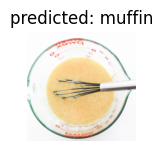

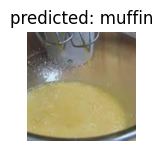

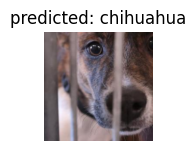

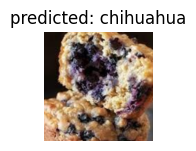

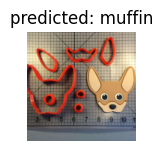

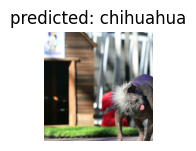

In [15]:
visualize_model(model_vit)

plt.ioff()
plt.show()

# Swin_s

In [17]:
model_swin = models.swin_s(weights='IMAGENET1K_V1')

num_ftrs = model_swin.head.in_features
model_swin.head = nn.Linear(num_ftrs, 2)

model_swin = model_swin.to(device)

optimizer_swin = optim.AdamW(model_swin.parameters(), lr=learning_rate)
T_max = num_epochs  
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_swin, T_max=T_max)

get_params_number(model_swin)

Downloading: "https://download.pytorch.org/models/swin_s-5e29d889.pth" to /root/.cache/torch/hub/checkpoints/swin_s-5e29d889.pth
100%|██████████| 190M/190M [00:01<00:00, 159MB/s]  


Total parameters: 48,838,796
Trainable parameters: 48,838,796


In [18]:
model_swin = train_model(model_swin, criterion, optimizer_swin, exp_lr_scheduler,
                       num_epochs=num_epochs)

evaluate_best_model(model_swin)

Epoch 0/19
----------
train Loss: 0.7476 Acc: 0.5085
val Loss: 0.6912 Acc: 0.5354

Epoch 1/19
----------
train Loss: 0.6915 Acc: 0.5346
val Loss: 0.6998 Acc: 0.4646

Epoch 2/19
----------
train Loss: 0.6953 Acc: 0.5238
val Loss: 0.6919 Acc: 0.5354

Epoch 3/19
----------
train Loss: 0.6916 Acc: 0.5367
val Loss: 0.6906 Acc: 0.5354

Epoch 4/19
----------
train Loss: 0.6915 Acc: 0.5401
val Loss: 0.6963 Acc: 0.4646

Epoch 5/19
----------
train Loss: 0.6905 Acc: 0.5322
val Loss: 0.6907 Acc: 0.5354

Epoch 6/19
----------
train Loss: 0.6902 Acc: 0.5420
val Loss: 0.6909 Acc: 0.5354

Epoch 7/19
----------
train Loss: 0.6906 Acc: 0.5420
val Loss: 0.6906 Acc: 0.5354

Epoch 8/19
----------
train Loss: 0.6903 Acc: 0.5420
val Loss: 0.6907 Acc: 0.5354

Epoch 9/19
----------
train Loss: 0.6904 Acc: 0.5420
val Loss: 0.6908 Acc: 0.5354

Epoch 10/19
----------
train Loss: 0.6903 Acc: 0.5399
val Loss: 0.6906 Acc: 0.5354

Epoch 11/19
----------
train Loss: 0.6905 Acc: 0.5420
val Loss: 0.6906 Acc: 0.5354

Ep

tensor(0.5405, device='cuda:0', dtype=torch.float64)

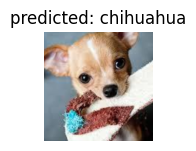

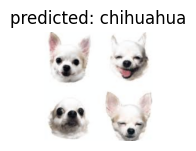

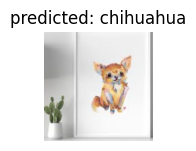

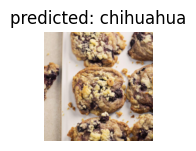

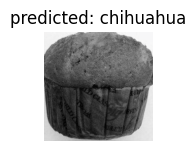

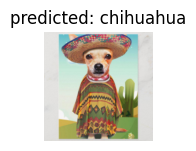

In [19]:
visualize_model(model_swin)

plt.ioff()
plt.show()